In [2]:
#First out imports
#Lets import some stuff!
from datetime import datetime
import os
import tempfile
import platform
from boto.s3.connection import S3Connection
import cartopy
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
import matplotlib
import netCDF4
import numpy as np
import pyart
import pytz
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import copy
import operator
import imp
radar_codes = imp.load_source('processing_code', '/Users/scollis/projects/xsapr_sgp/code/processing_code.py')

%matplotlib inline


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-19 08:54:42.413295. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
my_system = platform.system()
if my_system == 'Darwin':
    top = '/data/sample_sapr_data/sgpstage/sur/'
    soundings_dir = '/data/sample_sapr_data/sgpstage/interp_sonde/'
elif my_system == 'Linux':
    top = '/lcrc/group/earthscience/radar/sgpstage/sur/'
    soundings_dir = '/lcrc/group/earthscience/radar/interp_sonde/'


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:06.213597. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data

    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    #Connect to the bucket

    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    #Get a list of files

    bucket_list = list(bucket.list(prefix = my_pref))

    #we are going to create a list of keys and datetimes to allow easy searching

    keys = []
    datetimes = []

    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:06.225032. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
radar = pyart.io.read('/data/xsapr_test_case/XSW170329000004.RAWG6E5')
radar.altitude['data'][0] = 320.0

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:06.267558. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


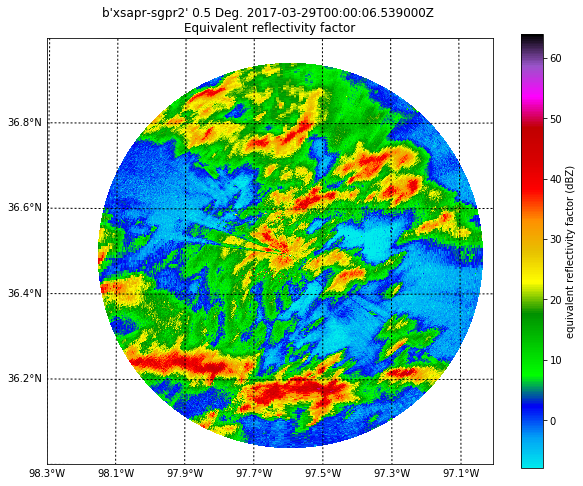

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:07.406213. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [5]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_wide.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


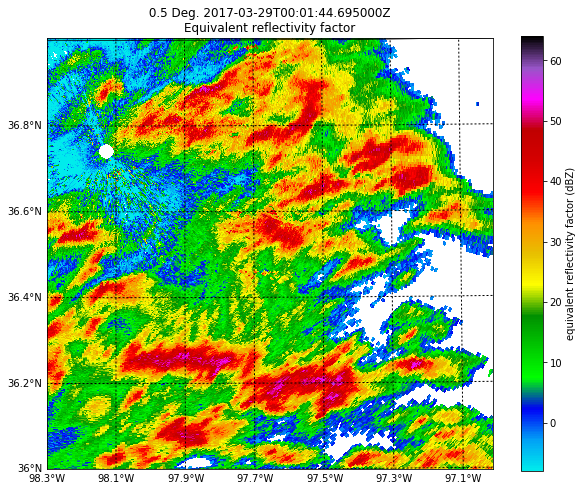

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:09.314598. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [6]:
    time_at_start_of_radar = netCDF4.num2date(radar.time['data'][0], 
                                          radar.time['units'])
    my_radar = get_radar_from_aws('KVNX', time_at_start_of_radar )
display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/kvnx_wide.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


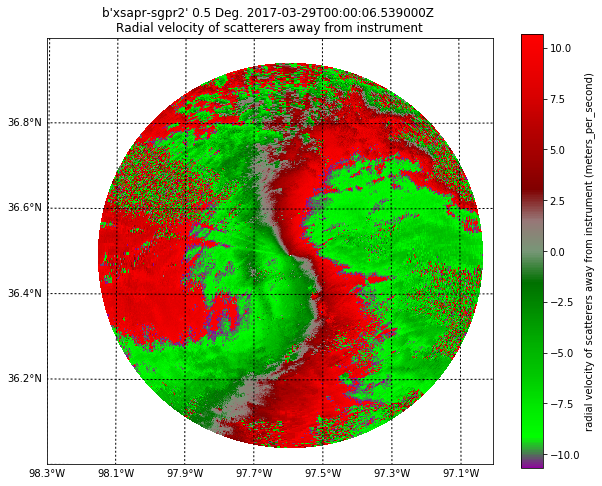

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:26.966761. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 0, resolution = 'c',
                    vmin = -10.7, vmax = 10.7, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/vel_data.png')

In [8]:
print(radar.fixed_angle['data'])

[  0.49987793   1.49963379   2.49938965   3.49914551   4.49890137
   5.49865723   6.49841309   7.49816895   8.4979248    9.49768066
  10.49743652  11.50268555  12.50244141  14.0020752   15.00183105
  17.00134277  20.00061035  24.99938965  29.99816895  40.0012207
  49.9987793   54.99755859  60.00183105]


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:28.891936. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
#guess a whole heap of data
radar_start_date = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
print(radar_start_date)
ymd_string = datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.strftime(radar_start_date, '%H%M%S')
print(ymd_string, hms_string)

2017-03-29 00:00:06.539000
20170329 000006


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:28.902622. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [10]:
sndfile = '/data/sgpsonde/sgpsondewnpnC1.b1.20170328.172700.cdf'
#z_dict, temp_dict, snr = radar_codes.snr_and_sounding(radar, 
#                                                      soundings_dir,
#                                                     override_file=sndfile)

sonde = netCDF4.Dataset(sndfile)

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:28.916545. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
print(sonde.variables.keys())

odict_keys(['base_time', 'time_offset', 'time', 'qc_time', 'pres', 'qc_pres', 'tdry', 'qc_tdry', 'dp', 'qc_dp', 'wspd', 'qc_wspd', 'deg', 'qc_deg', 'rh', 'qc_rh', 'u_wind', 'qc_u_wind', 'v_wind', 'qc_v_wind', 'wstat', 'asc', 'qc_asc', 'lat', 'lon', 'alt'])


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:28.927507. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:

z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(sonde.variables['tdry'][:],
                                             sonde.variables['alt'][:],
                                             radar)
    

texture =  radar_codes.get_texture(radar)

199.3379168510437


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 13:47:28.938117. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [14]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:00.224545. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
radar.add_field('sounding_temperature', temp_dict, replace_existing = True)
radar.add_field('height', z_dict, replace_existing = True)
radar.add_field('SNR', snr, replace_existing = True)
radar.add_field('velocity_texture', texture, replace_existing = True)
print(radar.fields.keys())

dict_keys(['SNR', 'spectrum_width', 'cross_correlation_ratio', 'specific_differential_phase', 'normalized_coherent_power', 'reflectivity', 'velocity', 'total_power', 'sounding_temperature', 'differential_phase', 'height', 'velocity_texture', 'differential_reflectivity'])


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:21.941208. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


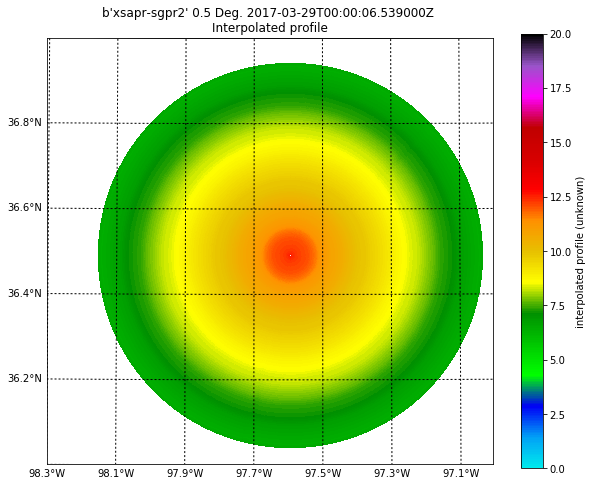

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:23.751223. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('sounding_temperature', sweep = 0, resolution = 'c',
                    vmin = -0, vmax = 20, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/temp_data.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


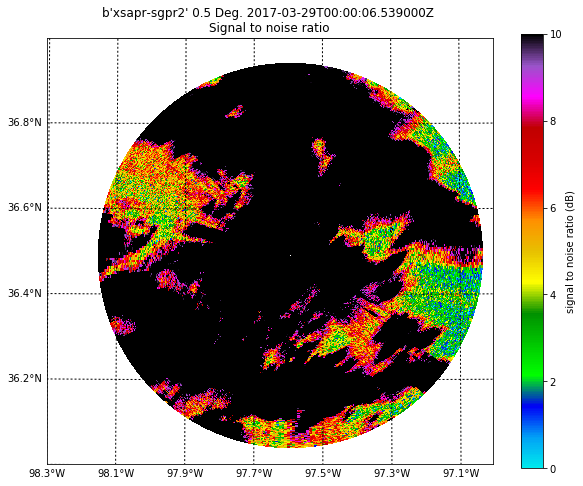

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:25.954636. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('SNR', sweep = 0, resolution = 'c',
                    vmin = 0, vmax = 10, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/snr_data.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


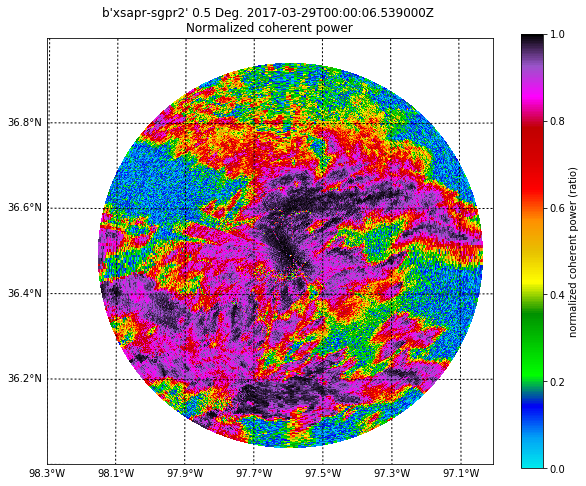

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:28.291421. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('normalized_coherent_power', sweep = 0, resolution = 'c',
                    vmin = 0, vmax = 1, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/ncp_data.png')

In [19]:
radar_codes = imp.load_source('processing_code', '/Users/scollis/projects/xsapr_sgp/code/processing_code.py')
my_fuzz, cats = radar_codes.do_my_fuzz(radar)
print(my_fuzz['notes'])
radar.add_field('gate_id', my_fuzz, 
                      replace_existing = True)

print(radar.fields['gate_id']['notes'])
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print(pair_str)
    cat_dict.update({pair_str.split(':')[1]:int(pair_str.split(':')[0])})

sorted_cats = sorted(cat_dict.items(), key=operator.itemgetter(1))


doing
Doing rain
Doing snow
Doing multi_trip
Doing no_scatter
Doing melting
Doing hard constraining  melting
(array([   0,    0,    0, ..., 9199, 9199, 9199]), array([ 0,  1,  2, ..., 19, 20, 21]))
Doing hard constraining  multi_trip
(array([4400, 4400, 4400, ..., 9199, 9199, 9199]), array([480, 481, 482, ..., 498, 499, 500]))
Doing hard constraining  melting
(array([1600, 1600, 1600, ..., 9199, 9199, 9199]), array([450, 451, 452, ..., 498, 499, 500]))
Doing hard constraining  rain
(array([2000, 2000, 2000, ..., 9199, 9199, 9199]), array([426, 427, 428, ..., 275, 276, 277]))
Doing hard constraining  melting
(array([   0,    0,    0, ..., 9199, 9199, 9199]), array([  0,   1,   2, ..., 498, 499, 500]))
1
0:rain,1:snow,2:multi_trip,3:no_scatter,4:melting
0:rain,1:snow,2:multi_trip,3:no_scatter,4:melting
0:rain
1:snow
2:multi_trip
3:no_scatter
4:melting


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:31.361396. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


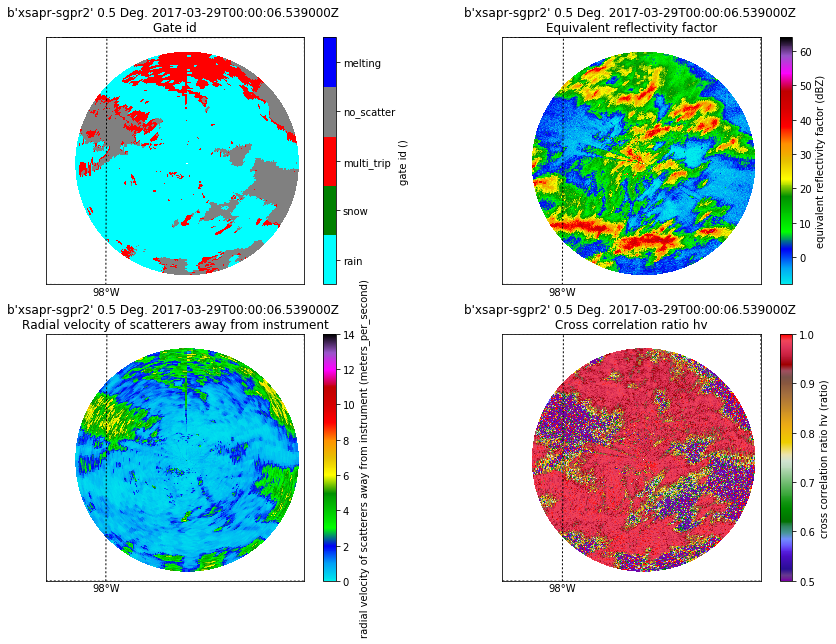

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:43.272553. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:

max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lat_lines = np.arange(min_lon, max_lon, .2)

sw = 0

display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['cyan','green', 'red', 'gray', 'blue' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = sw, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = sw, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity_texture', sweep = sw, vmin =0, vmax = 14, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep = sw, vmin = .5, vmax = 1,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.Carbone42)
plt.savefig('../images/cmac2_0p5.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


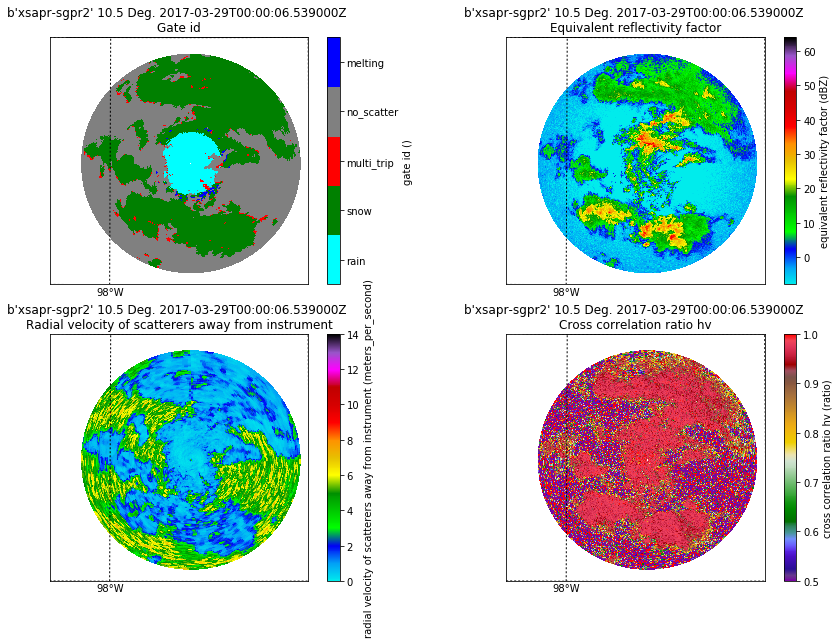

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:02:51.478945. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [21]:

max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lat_lines = np.arange(min_lon, max_lon, .2)

sw = 10

display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['cyan','green', 'red', 'gray', 'blue' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = sw, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = sw, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity_texture', sweep = sw, vmin =0, vmax = 14, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep = sw, vmin = .5, vmax = 1,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.Carbone42)
plt.savefig('../images/cmac2_0p5.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


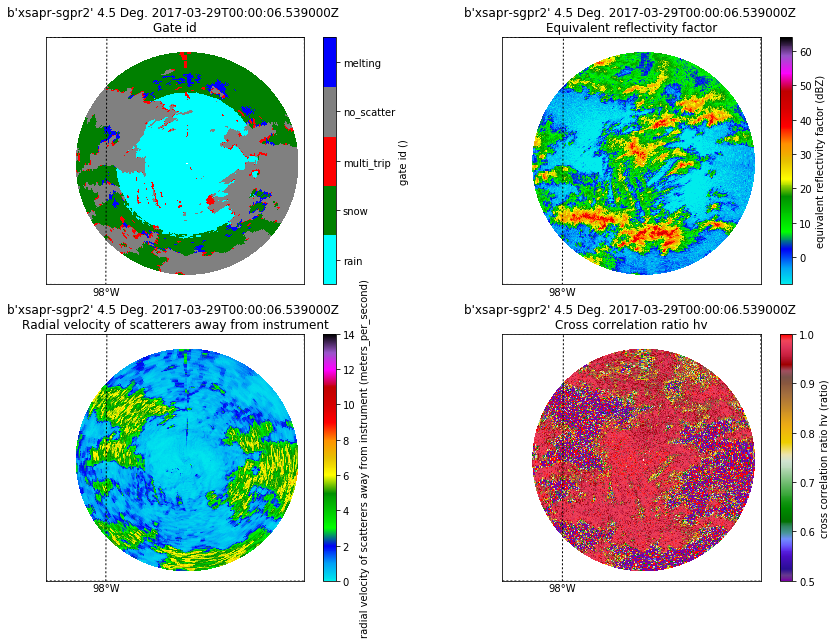

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:00.346236. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [22]:

max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lat_lines = np.arange(min_lon, max_lon, .2)

sw = 4

display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['cyan','green', 'red', 'gray', 'blue' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = sw, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
catty_list = [sorted_cats[i][0] for i in range(len(sorted_cats))]
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(catty_list)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = sw, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity_texture', sweep = sw, vmin =0, vmax = 14, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep = sw, vmin = .5, vmax = 1,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.Carbone42)
plt.savefig('../images/cmac2_0p5.png')

In [23]:
print(radar.fields['gate_id']['notes'])
cat_dict = {}
for pair_str in radar.fields['gate_id']['notes'].split(','):
    print(pair_str)
    cat_dict.update({pair_str.split(':')[1]:int(pair_str.split(':')[0])})


0:rain,1:snow,2:multi_trip,3:no_scatter,4:melting
0:rain
1:snow
2:multi_trip
3:no_scatter
4:melting


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:08.518752. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
print(cat_dict)

{'rain': 0, 'snow': 1, 'multi_trip': 2, 'no_scatter': 3, 'melting': 4}


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:08.535689. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [25]:

happy_gates = pyart.correct.GateFilter(radar)
happy_gates.exclude_all()
happy_gates.include_equal('gate_id', cat_dict['rain'])
happy_gates.include_equal('gate_id', cat_dict['melting'])
happy_gates.include_equal('gate_id', cat_dict['snow'])


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:08.551714. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


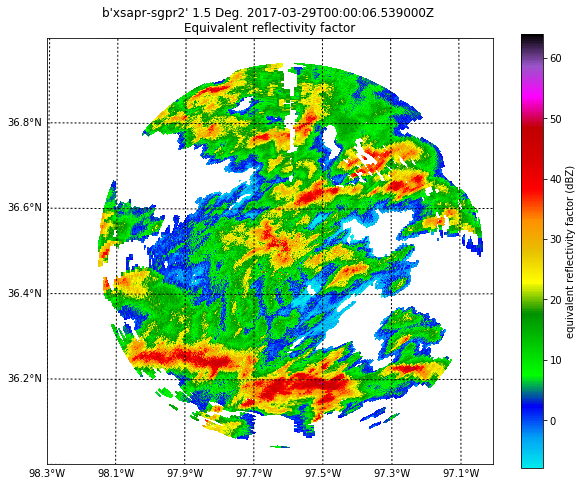

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:08.599905. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 1, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol, gatefilter=happy_gates)
plt.savefig('../images/windfarm_x_wide_happy.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


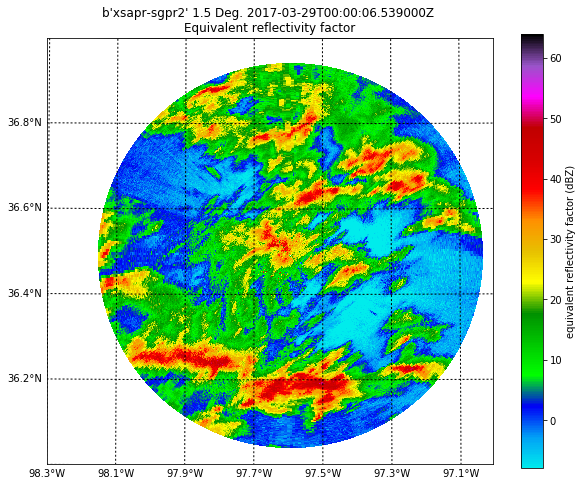

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:10.564307. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [27]:
max_lat = 37
min_lat = 36
min_lon = -98.3
max_lon = -97

lal = np.arange(min_lat, max_lat, .2)
lol = np.arange(min_lon, max_lon, .2)

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 1, resolution = 'c',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)
plt.savefig('../images/windfarm_x_wide_unhappy.png')

In [28]:
grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(46, 251, 251),
        grid_limits=((0, 15000.0),(-50000, 50000), (-50000, 50000)),
        fields=list(radar.fields.keys()), gridding_algo="map_gates_to_grid",
        weighting_function='BARNES', gatefilters=(happy_gates,), min_radius=200.0)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:12.652275. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


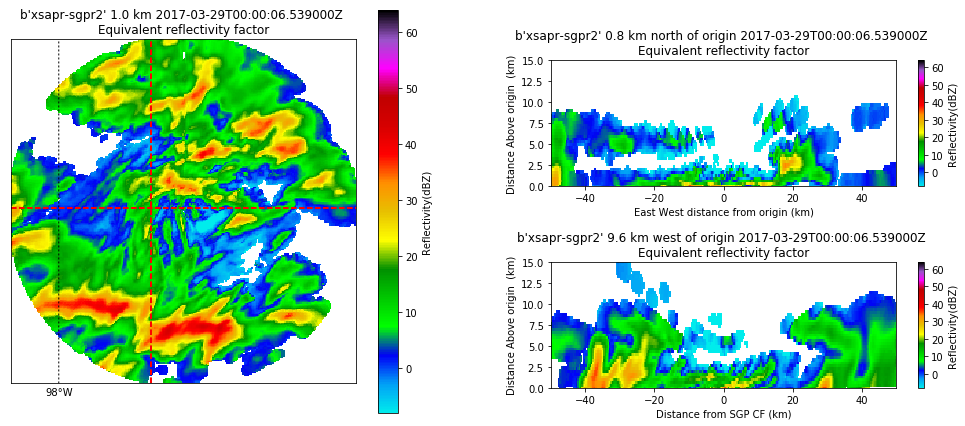

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:27.305018. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [29]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# parameters
level = 3
vmin = -8
vmax = 64
lat = 36.5
lon = -97.7

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2) )
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap = pyart.graph.cm.NWSRef)
ax2.set_ylim([0,15])
ax2.set_xlim([-50,50])
ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,15])
ax3.set_xlim([-50,50])
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                           cmap = pyart.graph.cm.NWSRef)
plt.savefig('../images/z_grid.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


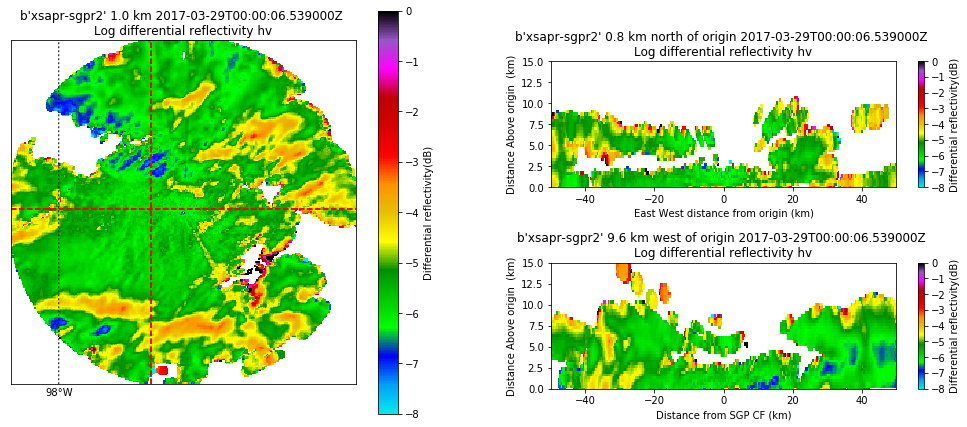

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:30.189976. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# parameters
level = 3
vmin = -8
vmax = 0
lat = 36.5
lon = -97.7

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2) )
display.plot_grid('differential_reflectivity', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap = pyart.graph.cm.NWSRef)
ax2.set_ylim([0,15])
ax2.set_xlim([-50,50])
ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,15])
ax3.set_xlim([-50,50])
display.plot_latitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                           cmap = pyart.graph.cm.NWSRef)
plt.savefig('../images/zdr_grid.png')

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


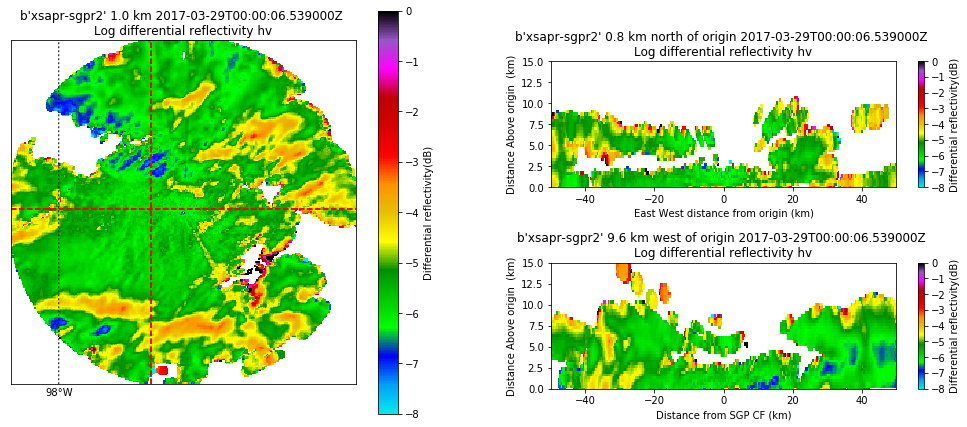

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:03:32.847738. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [31]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# parameters
level = 3
vmin = -8
vmax = 0
lat = 36.5
lon = -97.7

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 2) )
display.plot_grid('differential_reflectivity', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap = pyart.graph.cm.NWSRef)
ax2.set_ylim([0,15])
ax2.set_xlim([-50,50])
ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,15])
ax3.set_xlim([-50,50])
display.plot_latitude_slice('differential_reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                           cmap = pyart.graph.cm.NWSRef)

In [35]:
import yt

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:06:01.525275. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [36]:
arr = grids.fields['reflectivity']['data']
ff = arr.transpose()

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:06:13.577770. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [141]:
data = dict(density = (ff, "((mm**6)/(m**3))"))
bbox = np.array([[-50000., 50000.], [-50000., 50000.],[0., 15000.0]])
ds = yt.load_uniform_grid(data, ff.shape, length_unit="m", bbox=bbox)


yt : [INFO     ] 2017-03-30 17:12:32,938 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-30 17:12:32,940 Parameters: domain_dimensions         = [251 251  46]
yt : [INFO     ] 2017-03-30 17:12:32,943 Parameters: domain_left_edge          = [-50000. -50000.      0.]
yt : [INFO     ] 2017-03-30 17:12:32,948 Parameters: domain_right_edge         = [ 50000.  50000.  15000.]
yt : [INFO     ] 2017-03-30 17:12:32,951 Parameters: cosmological_simulation   = 0.0
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-30 17:12:32.928253. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/yt/arraytypes.py:34: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  blanks.append(np.zeros(elements, dtype=atype))
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/yt/arraytypes.py:34: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  blanks.append(np.zeros(elements, dtype=atype))
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/yt/arraytypes.py:34: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  blanks.append(np.zeros(elements, dtype=atype))
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/numpy/core/records.py:158: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  dtype = sb.dtype(formats, aligned)
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages


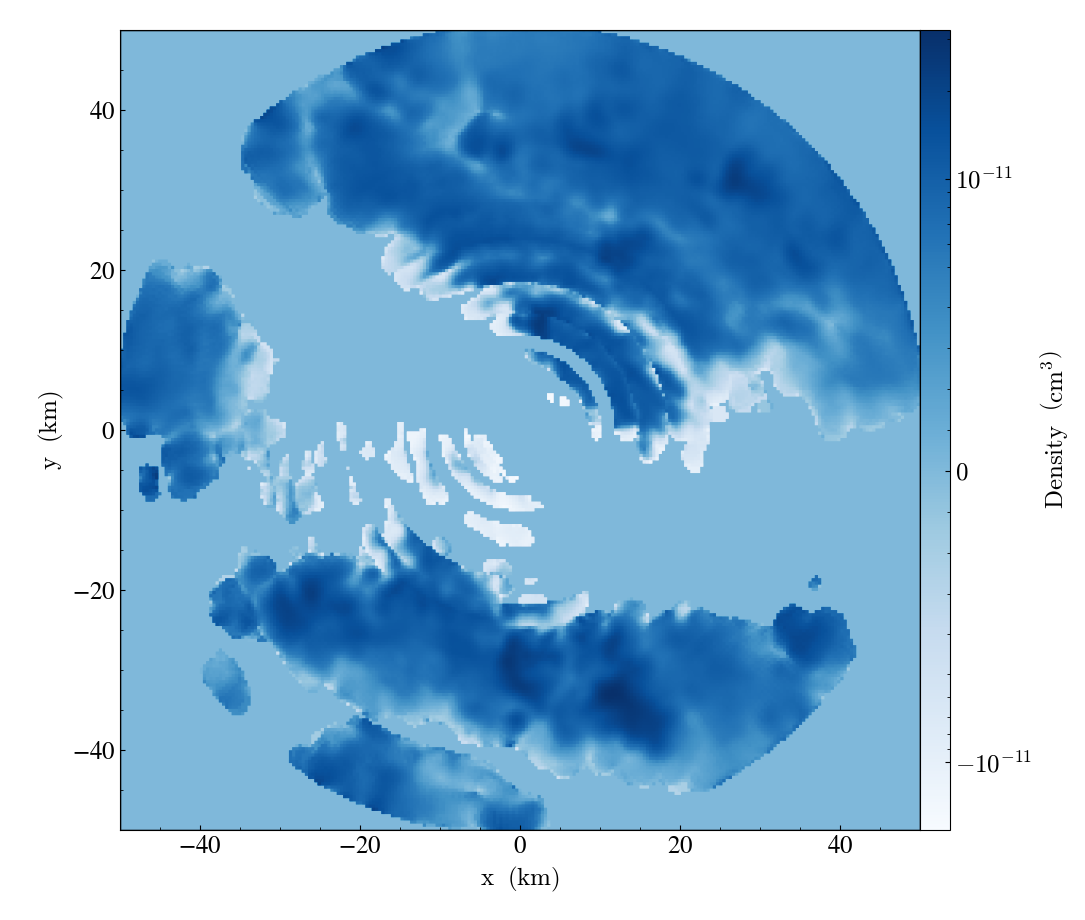

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-30 17:12:33.563477. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [142]:
slc = yt.SlicePlot(ds, "z", ["density"])
slc.set_cmap("density", "Blues")
slc.annotate_grids(cmap=None)
slc.show()

yt : [INFO     ] 2017-03-30 14:56:50,565 Setting default field to ('gas', 'density')
yt : [INFO     ] 2017-03-30 14:56:50,592 Creating transfer function
yt : [INFO     ] 2017-03-30 14:56:50,594 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.
/Users/scollis/anaconda/envs/xsapr/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
yt : [INFO     ] 2017-03-30 14:56:50,667 Rendering scene (Can take a while).
yt : [INFO     ] 2017-03-30 14:56:50,694 Creating volume
yt : [INFO     ] 2017-03-30 14:57:00,264 Saving render ../images/yt_test.png


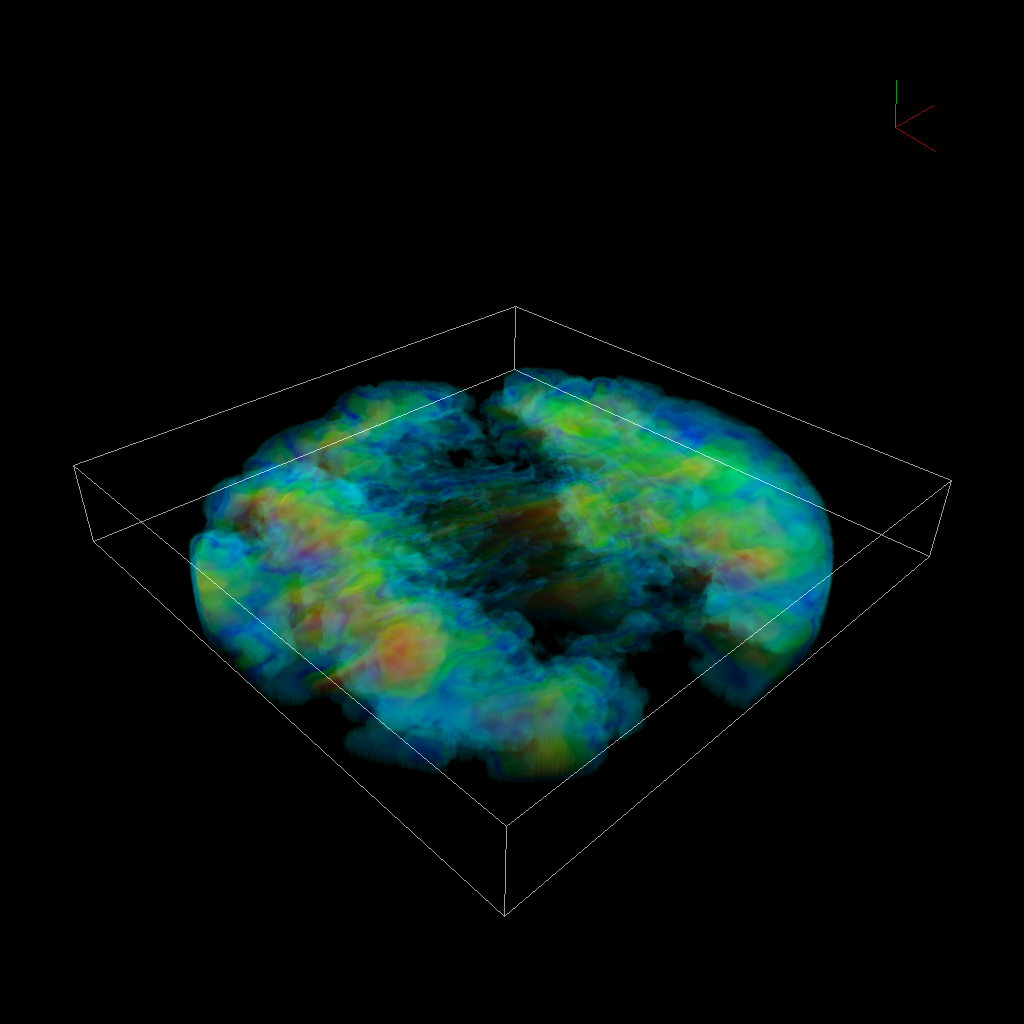

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-30 14:56:50.553394. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [99]:
sc = yt.create_scene(ds, lens_type='perspective')

source = sc[0]

source.set_field('density')
source.set_log(False)

# Modify the transfer function
sc.camera.focus = ds.domain_center
sc.camera.resolution = 1024

sc.camera.roll(np.pi)
# Move the camera position to the other side of the dataset
sc.camera.position = ds.arr([1,-1, 1], 'unitary')

# First get the render source, in this case the entire domain, with field ('gas','density')
render_source = sc.get_source(0)

# Clear the transfer function
render_source.transfer_function.clear()
# Map a range of density values (in log space) to the Reds_r colormap
render_source.transfer_function.map_to_colormap(
    ds.quan(-10.0, 'g/cm**3'),
    ds.quan(64., 'g/cm**3'),
    scale=15.0, colormap=pyart.graph.cm.NWSRef)

# Draw the domain boundary
sc.annotate_axes(alpha=.52)

sc.annotate_domain(ds, color=[1, 1, 1, 0.51])

sc.save('../images/yt_test.png')
sc.show()


yt : [INFO     ] 2017-03-30 17:12:46,343 Setting default field to ('gas', 'density')
yt : [INFO     ] 2017-03-30 17:12:47,286 Rendering scene (Can take a while).
yt : [INFO     ] 2017-03-30 17:12:47,303 Creating volume


TypeError: slice indices must be integers or None or have an __index__ method

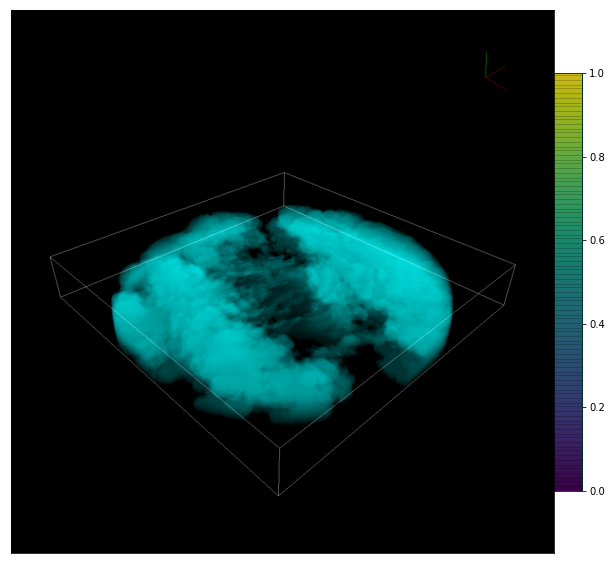

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-30 17:12:46.325844. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [143]:
sc = yt.create_scene(ds, lens_type='perspective')
source = sc[0]
source.set_field('density')
source.set_log(False)

sc.camera.focus = ds.domain_center
sc.camera.resolution = 1024
sc.camera.roll(np.pi)
sc.camera.position = ds.arr([1,-1, 1], 'unitary')

bounds = (0.,64.)
render_source = sc.get_source(0)
tf = yt.ColorTransferFunction(bounds)

def linramp(vals, minval, maxval):
    return 1

tf.map_to_colormap(-10, 64, colormap=pyart.graph.cm.NWSRef,
                  scale_func=linramp, scale=15)

source.tfh.tf = tf
source.tfh.set_log(False)

source.tfh.bounds = bounds

source.tfh.plot('transfer_function.png', profile_field='density')

# Draw the domain boundary
sc.annotate_axes(alpha=.52)

sc.annotate_domain(ds, color=[1, 1, 1, 0.51])
sc.save_annotated("../images/vol_annotated.png", sigma_clip=6)
#sc.save('../images/yt_test.png')
sc.show()


In [92]:
sc.annotate_domain?

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:57:39.079052. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [86]:
sc.camera.roll?

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-29 14:50:39.928857. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [106]:
tf.add_gaussian?

/Users/scollis/anaconda/envs/xsapr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-03-30 15:03:52.306877. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
pyart.io.read?

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-04-13 13:34:04.901526. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
